In [2]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation

pi = np.pi

This extends the double pedulum to a triple pendulum and animates it. First, we will set up some basic values and functions

In [3]:
#defines values
t, g = smp.symbols('t, g')
m1, m2, m3 = smp.symbols('m1, m2, m3')
L1, L2, L3 = smp.symbols('L1, L2, L3')

phi1, phi2, phi3 = smp.symbols(r'\phi_1, \phi_2, \phi_3', cls=smp.Function)


#makes angle a function of time
phi1 = phi1(t)
phi2 = phi2(t)
phi3 = phi3(t)


#sets first and second derivatives for angle
d_phi1 = smp.diff(phi1, t)
d_phi2 = smp.diff(phi2, t)
d_phi3 = smp.diff(phi3, t)
dd_phi1 = smp.diff(d_phi1, t)
dd_phi2 = smp.diff(d_phi2, t)
dd_phi3 = smp.diff(d_phi3, t)


#converts to cartesian coordinates
x1 = L1*smp.sin(phi1)
y1 = -L1*smp.cos(phi1)

x2 = L1*smp.sin(phi1) + L2*smp.sin(phi2)
y2 = -L1*smp.cos(phi1) - L2*smp.cos(phi2)

x3 = L1*smp.sin(phi1) + L2*smp.sin(phi2) + L3*smp.sin(phi3)
y3 = -L1*smp.cos(phi1) - L2*smp.cos(phi2) - L3*smp.cos(phi3)

To avoid doing a ton of heavy algebra and risking errors, we will run the lagrangian mechanical equations of motion inside of python. Then we can solve the resulting differential equations like with the double pendulum.

In [4]:
#kinetic energy
T1 = 1/2 * m1 * ( smp.diff(x1, t)**2 + smp.diff(y1, t)**2 )
T2 = 1/2 * m2 * ( smp.diff(x2, t)**2 + smp.diff(y2, t)**2 )
T3 = 1/2 * m3 * ( smp.diff(x3, t)**2 + smp.diff(y3, t)**2 )
T = T1+T2+T3

#potental energy
U1 = m1*g*y1
U2 = m2*g*y2
U3 = m3*g*y3
U = U1+U2+U3

#Lagrangian
L = T - U

In [5]:
#Plugging into the Euler-Lagrange equations. From here we solve the differential equations
ELE1 = smp.diff(L, phi1) - smp.diff(smp.diff(L, d_phi1), t).simplify()
ELE2 = smp.diff(L, phi2) - smp.diff(smp.diff(L, d_phi2), t).simplify()
ELE3 = smp.diff(L, phi3) - smp.diff(smp.diff(L, d_phi3), t).simplify()

In [6]:
#this may take several minutes or longer to run, depending on your computer
sol = smp.solve([ELE1, ELE2, ELE3], (dd_phi1, dd_phi2, dd_phi3),
                simplify=False, rational=True)

In [7]:
dz1dt_f = smp.lambdify((t, g, m1, m2, m3, L1, L2, L3, phi1, phi2, phi3, d_phi1, d_phi2, d_phi3), sol[dd_phi1])
dz2dt_f = smp.lambdify((t, g, m1, m2, m3, L1, L2, L3, phi1, phi2, phi3, d_phi1, d_phi2, d_phi3), sol[dd_phi2])
dz3dt_f = smp.lambdify((t, g, m1, m2, m3, L1, L2, L3, phi1, phi2, phi3, d_phi1, d_phi2, d_phi3), sol[dd_phi3])

dphi1dt_f = smp.lambdify(d_phi1, d_phi1)
dphi2dt_f = smp.lambdify(d_phi2, d_phi2)
dphi3dt_f = smp.lambdify(d_phi3, d_phi3)

In [8]:
def dSdt(S, t, g, m1, m2, m3, L1, L2, L3):
    phi1, z1, phi2, z2, phi3, z3 = S
    return [
        dphi1dt_f(z1),
        dz1dt_f(t, g, m1, m2, m3, L1, L2, L3, phi1, phi2, phi3, z1, z2, z3),
        
        dphi2dt_f(z2),
        dz2dt_f(t, g, m1, m2, m3, L1, L2, L3, phi1, phi2, phi3, z1, z2, z3),
        
        dphi3dt_f(z3),
        dz3dt_f(t, g, m1, m2, m3, L1, L2, L3, phi1, phi2, phi3, z1, z2, z3)
    ]

In [9]:
#initial conditions start completely horizontal and at rest, like with the double pendulum. All masses/lengths are 1
g = 9.8
m1 = 1
m2 = 1
m3 = 1
L1 = 1
L2 = 1
L3 = 1

t = np.linspace(0, 50, 1001)
S0 = (pi/2, 0, pi/2, 0, pi/2, 0)

#initial conditions start completely horizontal and at rest, like with the double pendulum
solution = odeint(dSdt, y0=S0, t=t, args=(g, m1, m2, m3, L1, L2, L3))

In [10]:
phi1 = solution.T[0]
phi2 = solution.T[2]
phi3 = solution.T[4]

def getxy(t, phi1, phi2, phi3, L1, L2, L3):
    return ( L1*np.sin(phi1), -L1*np.cos(phi1),
        L1*np.sin(phi1) + L2*np.sin(phi2), -L1*np.cos(phi1) - L2*np.cos(phi2),
        L1*np.sin(phi1) + L2*np.sin(phi2) + L3*np.sin(phi3), -L1*np.cos(phi1) - L2*np.cos(phi2) - L3*np.cos(phi3)
           )

x1, y1, x2, y2, x3, y3 = getxy(t, phi1, phi2, phi3, L1, L2, L3)

We now have everything we need to set up an animation of the triple pendulum

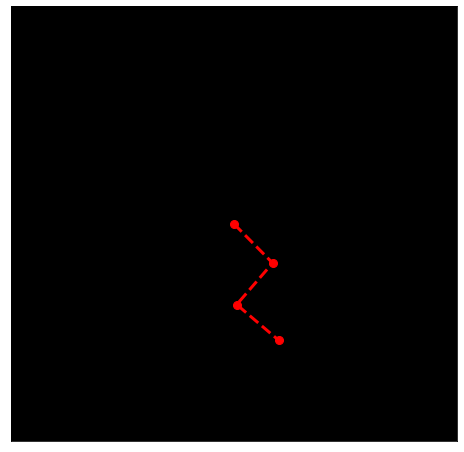

In [11]:
def animate(i):
    ln1.set_data( [0, x1[i], x2[i], x3[i]], [0, y1[i], y2[i], y3[i]] )

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_facecolor('black')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4, 4)
ax.set_xlim(-4, 4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('tripend.gif', writer='pillow', fps=20)